In [1]:
library(tidyverse)
library(tidyr)
library(ggsankey)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.1          ✔ readr     2.1.4     
✔ forcats   1.0.0.9000     ✔ stringr   1.5.0     
✔ ggplot2   3.4.1          ✔ tibble    3.2.1     
✔ lubridate 1.9.2          ✔ tidyr     1.3.0     
✔ purrr     1.0.1          
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# 4/17/2023

### Zm
bed_col_names <- c("chrom", "start", "stop", "acr_name_type", "pval")
broadly <- c("chrom", "start", "stop", "score", "acr_name_type")
zm_cts_acrs_rep1_file <- read_delim("/scratch/jpm73279/comparative_single_cell/dev_location/entropy_calc.CTs/updated/testing_replicate_merge.normalization_edgeR.FDR_split_rep1.all_cts.ACRs.bed", delim = "\t", col_names = bed_col_names)
zm_cts_acrs_rep2_file <- read_delim("/scratch/jpm73279/comparative_single_cell/dev_location/entropy_calc.CTs/updated/testing_replicate_merge.normalization_edgeR.FDR_split_rep2.all_cts.ACRs.bed",delim = "\t", col_names = bed_col_names)
zm_ctr_acrs_rep1_file <- read_delim("/scratch/jpm73279/comparative_single_cell/dev_location/entropy_calc.CTs/updated/testing_replicate_merge.normalization_edgeR.FDR_split_rep1.all_ctr.ACRs.bed",delim = "\t", col_names = bed_col_names)
zm_ctr_acrs_rep2_file <- read_delim("/scratch/jpm73279/comparative_single_cell/dev_location/entropy_calc.CTs/updated/testing_replicate_merge.normalization_edgeR.FDR_split_rep2.all_ctr.ACRs.bed",delim = "\t", col_names = bed_col_names)
#zm_broadly_acc_acrs_rep1_file <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/zm/Zm.final_acr_classification.rep1.upatedbroadly_accessible.ACRs.bed" ,delim = "\t", col_names = bed_col_names)
#zm_broadly_acc_acrs_rep2_file <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/replicate_analysis_one_off/zm/Zm.final_acr_classification.rep2.updatedbroadly_accessible.ACRs.bed" ,delim = "\t", col_names = bed_col_names)



count_function <- function(cts_acc,ctr_acc) {
    
    ctr_acc_fixed_named <- ctr_acc  %>% 
        tidyr::separate(acr_name_type, c("acr", "cell_type"), sep = ";")  %>% 
        #mutate(cell_type = "cell_type_restricted")  %>% 
        mutate_at(vars(pval),factor)
    
    combined_vals <- cts_acc  %>% 
        tidyr::separate(acr_name_type, c("acr", "cell_type"), sep = ";")  %>% 
        mutate_at(vars(pval),factor)  %>% 
        bind_rows(ctr_acc_fixed_named)
    
    return(combined_vals)
    
}

zm_acrs_rep1 <- count_function(zm_cts_acrs_rep1_file,zm_ctr_acrs_rep1_file)  %>% 
    mutate(rep = "rep1")
zm_acrs_rep2 <- count_function(zm_cts_acrs_rep2_file, zm_ctr_acrs_rep2_file)  %>% 
    mutate(rep = "rep2")

joined_zm_replicates <- full_join(zm_acrs_rep1, zm_acrs_rep2, by = c("chrom", "start", "stop", "acr"),
                        suffix = c(".rep1", ".rep2"))  %>% 
    group_by(cell_type.rep1, rep.rep1, cell_type.rep2, rep.rep2)  %>% 
    summarise(counts = n())


Rows: 2917 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, acr_name_type
dbl (3): start, stop, pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3166 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, acr_name_type
dbl (3): start, stop, pval

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 5344 Columns: 5
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3

In [3]:
zm_switching_quant <-  full_join(zm_acrs_rep1, zm_acrs_rep2, by = c("chrom", "start", "stop", "acr"),
                        suffix = c(".rep1", ".rep2"))  %>% 
    dplyr::mutate(classification = case_when(cell_type.rep1 == cell_type.rep2 ~ "conserved",
                                     TRUE ~ "switching"))  %>% 
    dplyr::group_by(classification)  %>% 
    summarise(counts = n())


In [4]:
zm_switching_quant <-  full_join(zm_acrs_rep1, zm_acrs_rep2, by = c("chrom", "start", "stop", "acr"),
                        suffix = c(".rep1", ".rep2")) 


zm_categorize <- zm_switching_quant  %>% 
    dplyr::filter(is.na(cell_type.rep2) != TRUE & is.na(cell_type.rep1) != TRUE)  %>% 
    dplyr::mutate(classification = case_when(cell_type.rep1 == cell_type.rep2 ~ "conserved",
                                     TRUE ~ "switching")) 

In [5]:
zm_categorize

chrom,start,stop,acr,cell_type.rep1,pval.rep1,rep.rep1,cell_type.rep2,pval.rep2,rep.rep2,classification
<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<chr>,<chr>
chr9,56998266,56998767,scACR_51717,bundle_sheath_n_cell_2878,0.0553301472232691,rep1,"bundle_sheath_n_cell_2878,mesophyll_n_cell_4657","0.0666646054982711,0.071973850842782",rep2,switching
chr2,82587011,82587512,scACR_14973,bundle_sheath_n_cell_2878,0.0206520565442193,rep1,"bundle_sheath_n_cell_2878,procambial_meristem_n_cell_346","0.0012434093250868,0.0706367248013331",rep2,switching
chr3,111843117,111843618,scACR_20807,bundle_sheath_n_cell_2878,0.0150991781414936,rep1,"bundle_sheath_n_cell_2878,phloem_sieve_elements_n_cell_1471","0.0120398244928162,0.0463890477748621",rep2,switching
chr3,214669148,214669649,scACR_23868,bundle_sheath_n_cell_2878,0.0726958778386303,rep1,procambial_meristem_n_cell_346,0.0399501574298819,rep2,switching
chr6,143075246,143075747,scACR_39397,bundle_sheath_n_cell_2878,0.00497109201300757,rep1,"bundle_sheath_n_cell_2878,mesophyll_desc_developing_n_cell_510","0.00108169819889866,0.0177693239553929",rep2,switching
chr3,201023366,201023867,scACR_23241,bundle_sheath_n_cell_2878,0.0157624868331537,rep1,"bundle_sheath_n_cell_2878,companion_cells_n_cell_689,phloem_sieve_elements_n_cell_1471","0.0231215854952347,0.0140417997268834,0.076828700141961",rep2,switching
chr7,135255271,135255772,scACR_43581,bundle_sheath_n_cell_2878,0.0860313058125251,rep1,"bundle_sheath_n_cell_2878,companion_cells_n_cell_689","0.0509343375479902,0.0337544029670134",rep2,switching
chr5,19987761,19988262,scACR_31450,bundle_sheath_n_cell_2878,0.0477329623333077,rep1,bundle_sheath_n_cell_2878,0.0554181689730066,rep2,conserved
chr5,212223138,212223639,scACR_35825,bundle_sheath_n_cell_2878,0.0610301956391006,rep1,bundle_sheath_n_cell_2878,0.0749251486673862,rep2,conserved


In [6]:
good <- zm_categorize  %>% 
    dplyr::filter(classification == "switching")  %>% 
    sample_n(30)  %>% 
    dplyr::select(chrom,start,stop,acr,cell_type.rep1,pval.rep1,cell_type.rep2,pval.rep2)
good

chrom,start,stop,acr,cell_type.rep1,pval.rep1,cell_type.rep2,pval.rep2
<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<fct>
chr9,11946082,11946583,scACR_50734,"bundle_sheath_n_cell_2878,companion_cells_n_cell_689,phloem_sieve_elements_n_cell_1471","0.00412485626781815,0.00672733530233814,0.00386215654379831","companion_cells_n_cell_689,procambial_meristem_n_cell_346","0.0086303103313205,0.0940561984005307"
chr2,116732488,116732989,scACR_15404,"mesophyll_desc_developing_n_cell_510,phloem_sieve_elements_n_cell_1471","0.00278697201601822,0.080353439298158","mesophyll_desc_developing_n_cell_510,mesophyll_n_cell_4657,protoderm_n_cell_2021","0.0061761006649537,0.0080765778856028,0.0219666054027768"
chr9,21452942,21453443,scACR_51054,"companion_cells_n_cell_689,epidermis_n_cell_3488,protoderm_n_cell_2021","0.0193569073846843,0.0110659208370112,0.000110734076750282","companion_cells_n_cell_689,phloem_sieve_elements_n_cell_1471,protoderm_n_cell_2021","0.0615356239184562,0.00101043645796998,2.29495560166349e-06"
chr1,13547287,13547788,scACR_642,"epidermis_n_cell_3488,phloem_sieve_elements_n_cell_1471","0.0354277648386159,0.0717574655222375",phloem_sieve_elements_n_cell_1471,0.0601697300741322
chr9,148285725,148286226,scACR_53859,"bundle_sheath_n_cell_2878,mesophyll_desc_developing_n_cell_510,mesophyll_n_cell_4657","0.0128009344036598,0.0294332106176566,0.00341227054411472","bundle_sheath_n_cell_2878,epidermis_n_cell_3488,protoderm_n_cell_2021","0.0311111842559081,0.0324155314441124,0.0111261727497237"
chr9,89300707,89301208,scACR_52117,"epidermis_n_cell_3488,protoderm_n_cell_2021","0.00022382654763545,0.000206633797982303","epidermis_n_cell_3488,mesophyll_desc_developing_n_cell_510,protoderm_n_cell_2021","0.000482789638997512,0.0929754937890905,0.00163550889245041"
chr5,90618173,90618674,scACR_33166,"epidermis_n_cell_3488,phloem_sieve_elements_n_cell_1471,protoderm_n_cell_2021","0.000251398584363948,0.00119690167690139,4.14717481001211e-06","companion_cells_n_cell_689,epidermis_n_cell_3488,protoderm_n_cell_2021","0.0196909344441664,0.0260404088961797,0.00136794018581637"
chr7,112519448,112519949,scACR_42930,"companion_cells_n_cell_689,protoderm_n_cell_2021","0.0421862565533591,0.00242128927629765",phloem_sieve_elements_n_cell_1471,0.0173433487215834
chr10,86335710,86336211,scACR_10044,phloem_sieve_elements_n_cell_1471,0.00682579693078738,"mesophyll_desc_developing_n_cell_510,phloem_sieve_elements_n_cell_1471","0.00315995377775943,0.00113664964674973"


In [7]:
good <- zm_categorize  %>% 
    dplyr::filter(classification == "conserved")  %>% 
    sample_n(30)  %>% 
    dplyr::select(chrom,start,stop,acr,cell_type.rep1,pval.rep1,cell_type.rep2,pval.rep2)
good

chrom,start,stop,acr,cell_type.rep1,pval.rep1,cell_type.rep2,pval.rep2
<chr>,<dbl>,<dbl>,<chr>,<chr>,<fct>,<chr>,<fct>
chr8,149167632,149168133,scACR_48901,epidermis_n_cell_3488,0.0718460293329807,epidermis_n_cell_3488,0.0836648808782751
chr3,174168996,174169497,scACR_22170,"mesophyll_desc_developing_n_cell_510,phloem_sieve_elements_n_cell_1471,protoderm_n_cell_2021","8.87947002879974e-05,4.73080827590451e-07,0.0326919466043436","mesophyll_desc_developing_n_cell_510,phloem_sieve_elements_n_cell_1471,protoderm_n_cell_2021","0.002185529239775,4.89819329617409e-07,0.00241484950214164"
chr4,27787297,27787798,scACR_25571,"epidermis_n_cell_3488,protoderm_n_cell_2021","0.00898958242775786,0.0211119648370569","epidermis_n_cell_3488,protoderm_n_cell_2021","0.000471437752329465,0.00170632072147254"
chr9,150749237,150749738,scACR_53977,"bundle_sheath_n_cell_2878,procambial_meristem_n_cell_346","0.0129077286385028,0.00099846712148661","bundle_sheath_n_cell_2878,procambial_meristem_n_cell_346","0.0152920912271336,0.0866115165827478"
chr7,5514360,5514861,scACR_41386,"epidermis_n_cell_3488,protoderm_n_cell_2021","0.00443080807069097,0.0246072810459847","epidermis_n_cell_3488,protoderm_n_cell_2021","0.000330219143630624,0.000126709835065087"
chr10,2007914,2008415,scACR_8583,"epidermis_n_cell_3488,mesophyll_desc_developing_n_cell_510,protoderm_n_cell_2021","0.0694449114465948,0.0604880174680982,0.0250020221065455","epidermis_n_cell_3488,mesophyll_desc_developing_n_cell_510,protoderm_n_cell_2021","0.0769085037961571,0.0572825032481103,0.0933935928002559"
chr1,95532448,95532949,scACR_3220,"bundle_sheath_n_cell_2878,procambial_meristem_n_cell_346","0.0113172095739596,0.0389320728321359","bundle_sheath_n_cell_2878,procambial_meristem_n_cell_346","0.00533547271601692,0.00921353034388788"
chr1,224166705,224167206,scACR_5703,"mesophyll_desc_developing_n_cell_510,mesophyll_n_cell_4657,protoderm_n_cell_2021","6.93827168064651e-05,0.00938207147501465,0.041240252323168","mesophyll_desc_developing_n_cell_510,mesophyll_n_cell_4657,protoderm_n_cell_2021","0.00596927258021735,0.0176909878630636,0.0229202661337965"
chr1,29593538,29594039,scACR_1265,epidermis_n_cell_3488,0.0905411180363699,epidermis_n_cell_3488,0.0954005768333535


In [8]:
zm_split_switching <- zm_categorize %>% 
    separate_rows(cell_type.rep2, pval.rep2, sep = ",", convert = TRUE)  %>% 
    separate_rows(cell_type.rep1, pval.rep1, sep = ",", convert = TRUE)

ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: zm_split_switching  %>% 
2:     
  ^


In [10]:
zm_spread_longer <- zm_split_switching  %>% 
    select(acr:classification)  %>% 
    select(-rep.rep1, -rep.rep2)  %>% 
    pivot_longer(
    cols = c(cell_type.rep1, cell_type.rep2),
    names_to = "rep",
    values_to = "cell_type"
  ) %>%
  pivot_longer(
    cols = c(pval.rep1, pval.rep2),
    names_to = "rep_pval",
    values_to = "pval"
  ) %>%
  mutate(rep = recode(rep, "cell_type.rep1" = "rep1", "cell_type.rep2" = "rep2")) %>%
  filter(rep == str_replace(rep_pval, "pval.", "")) %>%
  select(acr, rep, cell_type, pval, classification)

head(zm_spread_longer)

acr,rep,cell_type,pval,classification
<chr>,<chr>,<chr>,<dbl>,<chr>
scACR_51717,rep1,bundle_sheath_n_cell_2878,0.055330147,switching
scACR_51717,rep2,bundle_sheath_n_cell_2878,0.066664605,switching
scACR_51717,rep1,bundle_sheath_n_cell_2878,0.055330147,switching
scACR_51717,rep2,mesophyll_n_cell_4657,0.071973851,switching
scACR_14973,rep1,bundle_sheath_n_cell_2878,0.020652057,switching
scACR_14973,rep2,bundle_sheath_n_cell_2878,0.001243409,switching


In [16]:
zm_split_switching %>%
    dplyr::select(chrom, start, stop, acr, cell_type.rep1, pval.rep1, cell_type.rep2, pval.rep2) %>%
    dplyr::filter(cell_type.rep1 != cell_type.rep2) %>%
    dplyr::arrange(acr, pval.rep1,pval.rep2) 
    

chrom,start,stop,acr,cell_type.rep1,pval.rep1,cell_type.rep2,pval.rep2
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>
chr10,85116996,85117497,scACR_10010,mesophyll_n_cell_4657,1.891769e-02,epidermis_n_cell_3488,6.488590e-02
chr10,85116996,85117497,scACR_10010,mesophyll_desc_developing_n_cell_510,6.168833e-02,mesophyll_n_cell_4657,2.077191e-02
chr10,85116996,85117497,scACR_10010,mesophyll_desc_developing_n_cell_510,6.168833e-02,epidermis_n_cell_3488,6.488590e-02
chr10,85116996,85117497,scACR_10010,epidermis_n_cell_3488,9.333465e-02,mesophyll_n_cell_4657,2.077191e-02
chr10,85201314,85201815,scACR_10013,epidermis_n_cell_3488,2.125522e-06,protoderm_n_cell_2021,9.019837e-04
chr10,85201314,85201815,scACR_10013,epidermis_n_cell_3488,2.125522e-06,mesophyll_n_cell_4657,2.078952e-02
chr10,85201314,85201815,scACR_10013,mesophyll_n_cell_4657,1.198639e-03,epidermis_n_cell_3488,2.566119e-05
chr10,85201314,85201815,scACR_10013,mesophyll_n_cell_4657,1.198639e-03,protoderm_n_cell_2021,9.019837e-04
chr10,85201314,85201815,scACR_10013,protoderm_n_cell_2021,1.567434e-03,epidermis_n_cell_3488,2.566119e-05


In [12]:
zm_split_switching  %>% 
    group_by(classification)  %>% 
    dplyr::summarize(cor(pval.rep1, pval.rep2))

classification,"cor(pval.rep1, pval.rep2)"
<chr>,<dbl>
conserved,0.2957336
switching,0.2178521


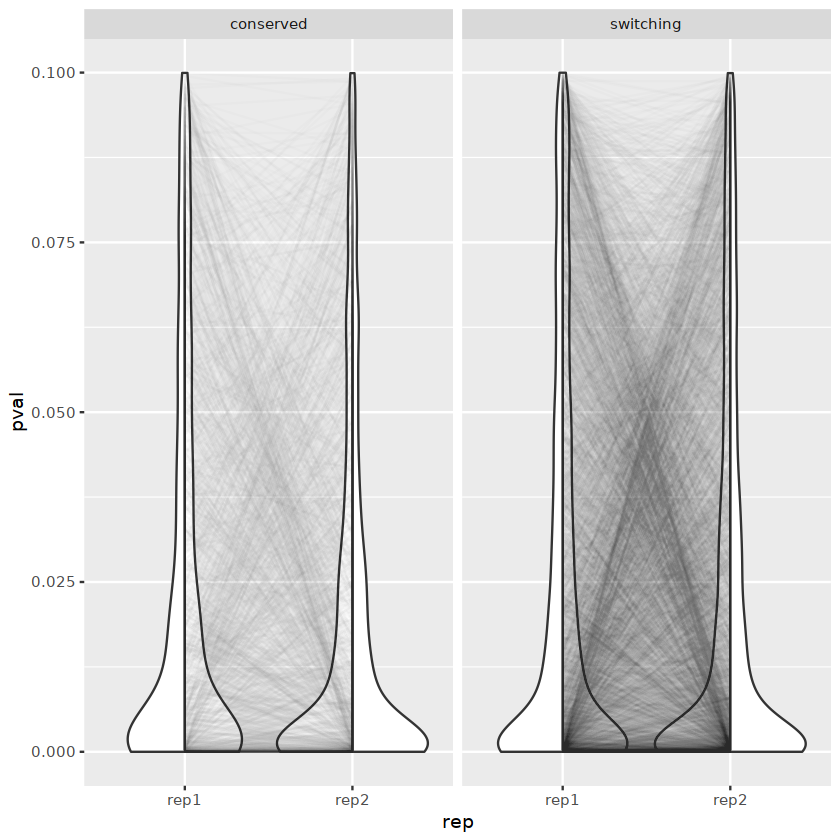

In [13]:
ggplot(zm_spread_longer, aes(x = rep, y = pval)) + facet_grid(.~classification) + 
    geom_violin() + geom_line(aes(group = acr), alpha = 0.01)
    